In [1]:
# ok maybe we just quasi-randomly sample mix rates, then can plot countor 

# do this for all the toy datasets and waterbirds 

# later we can do it for celebA-0 and multi-nli with mix rate 0.5 

In [1]:
import os 
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
from itertools import product
from pathlib import Path
from datetime import datetime
import copy

import optuna
import numpy as np

from losses.loss_types import LossType
from utils.exp_utils import get_study_args_dict, get_executor, run_experiments
from run_study import get_storage_path

/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N_TRIALS = 36 * 3
NODES_PER_STUDY = 3 # NOTE: this should be 13 but oh well
SAMPLER = "grid"
STUDY_SCRIPT_NAME = "run_study.py"

SCRIPT_NAME = "spur_corr_exp.py"


In [ ]:
HPARM_PARENT_DIR = Path("output/cc_mix_rate_lower_bound_grid_sweep")
HPARAM_DIR_NAME = None

if HPARAM_DIR_NAME is None:
    hparam_dir_name = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    hparam_dir = Path(HPARM_PARENT_DIR, hparam_dir_name)
    hparam_dir.mkdir(exist_ok=True, parents=True)
else:
    hparam_dir = Path(HPARM_PARENT_DIR, HPARAM_DIR_NAME)

In [4]:
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]

# using aux weight 1.0 for now

# TODO: add linear schedule

env_configs = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "batch_size": 32, "target_batch_size": 128, "lr": 1e-3, "optimizer": "sgd"},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "model": "Resnet50", "epochs": 5},
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": 5},
    "waterbirds": {"dataset": "waterbirds", "model": "Resnet50", "epochs": 5},
#     "celebA-0": {"dataset": "celebA-0", "model": "Resnet50", "epochs": 5},
#     "multi-nli": {"dataset": "multi-nli", "model": "bert", "epochs": 1, "lr": 1e-5, "combine_neut_entail": True, "contra_no_neg": True},
}


hparam_map = {
    "mix_rate_lower_bound_01": {"type": "float", "range": [0, 1], "log": False},
    "mix_rate_lower_bound_10": {"type": "float", "range": [0, 1], "log": False},
}

search_space = {
    "mix_rate_lower_bound_01": np.arange(0, 0.6, 0.1).tolist(),
    "mix_rate_lower_bound_10": np.arange(0, 0.6, 0.1).tolist(),
}



configs = {}
for (env_name, env_config), mix_rate in product(env_configs.items(), MIX_RATES):
    configs[(env_name, mix_rate)] = {
        **env_config, 
        "mix_rate": mix_rate, 
        "loss_type": LossType.TOPK,
        "mix_rate_lower_bound": None, 
        "mix_rate_schedule": "linear", 
        "mix_rate_t0": 0, 
        "mix_rate_t1": env_config["epochs"]
    }

dataset_to_mem_gb = {
    "toy_grid": 16,
    "fmnist_mnist": 16,
    "cifar_mnist": 16,
    "waterbirds": 16,
    "celebA-0": 32,
    "multi-nli": 32,
}

def get_study_name(env_name, mix_rate):
    return f"{env_name}_{mix_rate}"


# Run Experiments

In [6]:
for (env_name, mix_rate), conf in configs.items(): 
    study_name = get_study_name(env_name, mix_rate)
    study_dir = Path(hparam_dir, study_name)
    study_dir.mkdir(exist_ok=True, parents=True)
    
    # create study (must create it here to nodes don't conflict)
    study = optuna.create_study(study_name=study_name, storage=get_storage_path(study_dir), direction="minimize", load_if_exists=True)  
    
    # run study
    n_trials_per_node = N_TRIALS // NODES_PER_STUDY
    cmds = [
        {
            **get_study_args_dict(conf, SCRIPT_NAME, hparam_map, n_trials_per_node, 0, study_name, study_dir), 
            "sampler_seed": i, 
            "sampler_type": SAMPLER, 
            "search_space": search_space
        } for i in range(NODES_PER_STUDY)
    ]
    executor = get_executor(study_dir, mem_gb=dataset_to_mem_gb[env_name], slurm_array_parallelism=NODES_PER_STUDY)

    jobs = run_experiments(executor, cmds, STUDY_SCRIPT_NAME)

[I 2025-02-05 19:36:11,674] A new study created in RDB with name: toy_grid_0.1
[I 2025-02-05 19:36:12,182] A new study created in RDB with name: toy_grid_0.25
[I 2025-02-05 19:36:12,364] A new study created in RDB with name: toy_grid_0.5


[I 2025-02-05 19:36:12,492] A new study created in RDB with name: toy_grid_0.75
[I 2025-02-05 19:36:12,613] A new study created in RDB with name: toy_grid_1.0
[I 2025-02-05 19:36:12,747] A new study created in RDB with name: fmnist_mnist_0.1
[I 2025-02-05 19:36:12,866] A new study created in RDB with name: fmnist_mnist_0.25
[I 2025-02-05 19:36:12,985] A new study created in RDB with name: fmnist_mnist_0.5
[I 2025-02-05 19:36:13,106] A new study created in RDB with name: fmnist_mnist_0.75
[I 2025-02-05 19:36:13,230] A new study created in RDB with name: fmnist_mnist_1.0
[I 2025-02-05 19:36:13,435] A new study created in RDB with name: cifar_mnist_0.1
[I 2025-02-05 19:36:13,906] A new study created in RDB with name: cifar_mnist_0.25
[I 2025-02-05 19:36:14,056] A new study created in RDB with name: cifar_mnist_0.5
[I 2025-02-05 19:36:14,200] A new study created in RDB with name: cifar_mnist_0.75
[I 2025-02-05 19:36:14,345] A new study created in RDB with name: cifar_mnist_1.0
[I 2025-02-0

In [8]:
print(jobs[0].stderr())

None


# Process Results

In [5]:
# load study 
hparam_dir = "output/cc_mix_rate_lower_bound_grid_sweep/2025-02-05_19-35-58"

In [6]:
# so right now I want to do some exploratory analysis
# for example, for a given dataset and mix rate, plot the max source acc counter grid 
import json
import yaml
import pandas as pd
import numpy as np
# load all metrics in output/cc_mix_rate_lower_bound_sweep into a dataframe 
results = []
for study_dir in Path(hparam_dir).iterdir():
    if not study_dir.is_dir():
        continue
    for exp_dir in study_dir.iterdir():
        if not exp_dir.is_dir():
            continue
        if exp_dir.name == "0":
            continue
        metric_file = exp_dir / "metrics.json"
        config_file = exp_dir / "config.yaml"
        with open(metric_file, "r") as f:
            metrics = json.load(f)
        with open(config_file, "r") as f:
            config = yaml.safe_load(f)
        
        min_val_loss_idx = np.argmin(metrics["val_loss"])
        min_val_loss = metrics["val_loss"][min_val_loss_idx]

        source_acc_0 = metrics["val_source_acc_0"][min_val_loss_idx]
        source_acc_1 = metrics["val_source_acc_1"][min_val_loss_idx]
        max_source_acc = max(source_acc_0, source_acc_1)

        target_acc_0 = metrics["val_target_acc_0"][min_val_loss_idx]
        target_acc_1 = metrics["val_target_acc_1"][min_val_loss_idx]
        max_target_acc = max(target_acc_0, target_acc_1)

        test_acc_0 = metrics["test_acc_0"][min_val_loss_idx]
        test_acc_1 = metrics["test_acc_1"][min_val_loss_idx]
        max_test_acc = max(test_acc_0, test_acc_1)
        
       
        # Create a dictionary for each experiment
        result_dict = {
            'dataset': config["dataset"],
            'mix_rate': config["mix_rate"],
            'mix_rate_lb_01': config["mix_rate_lower_bound_01"],
            'mix_rate_lb_10': config["mix_rate_lower_bound_10"],
            'source_acc': max_source_acc,
            'target_acc': max_target_acc,
            'test_acc': max_test_acc,
            'study_dir': str(study_dir),
            'exp_dir': str(exp_dir)
        }
        results.append(result_dict)

df = pd.DataFrame(results)

In [8]:
df.to_csv(Path(hparam_dir) / "results.csv", index=False)

In [7]:
df

,dataset,mix_rate,mix_rate_lb_01,mix_rate_lb_10,source_acc,target_acc,test_acc,study_dir,exp_dir
0,cifar_mnist,0.10,0.3,0.4,0.832031,0.769531,0.663265,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
1,cifar_mnist,0.10,0.5,0.1,0.734375,0.703125,0.632653,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
2,cifar_mnist,0.10,0.1,0.0,0.996094,0.906250,0.497959,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
3,cifar_mnist,0.10,0.5,0.2,0.718750,0.644531,0.587755,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
4,cifar_mnist,0.10,0.3,0.4,0.988281,0.902344,0.629592,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
...,...,...,...,...,...,...,...,...,...
736,toy_grid,0.25,0.2,0.3,0.890625,0.917969,0.936000,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
737,toy_grid,0.25,0.3,0.0,0.500000,0.507812,0.500000,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
738,toy_grid,0.25,0.4,0.4,0.816406,0.863281,0.904000,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...
739,toy_grid,0.25,0.3,0.4,0.796875,0.835938,0.874000,output/cc_mix_rate_lower_bound_grid_sweep/2025...,output/cc_mix_rate_lower_bound_grid_sweep/2025...


In [ ]:
# for a given dataset and mix rate, plot conter (with x, y being mix_rate_lb_01 and mix_rate_lb_10, value max source acc)


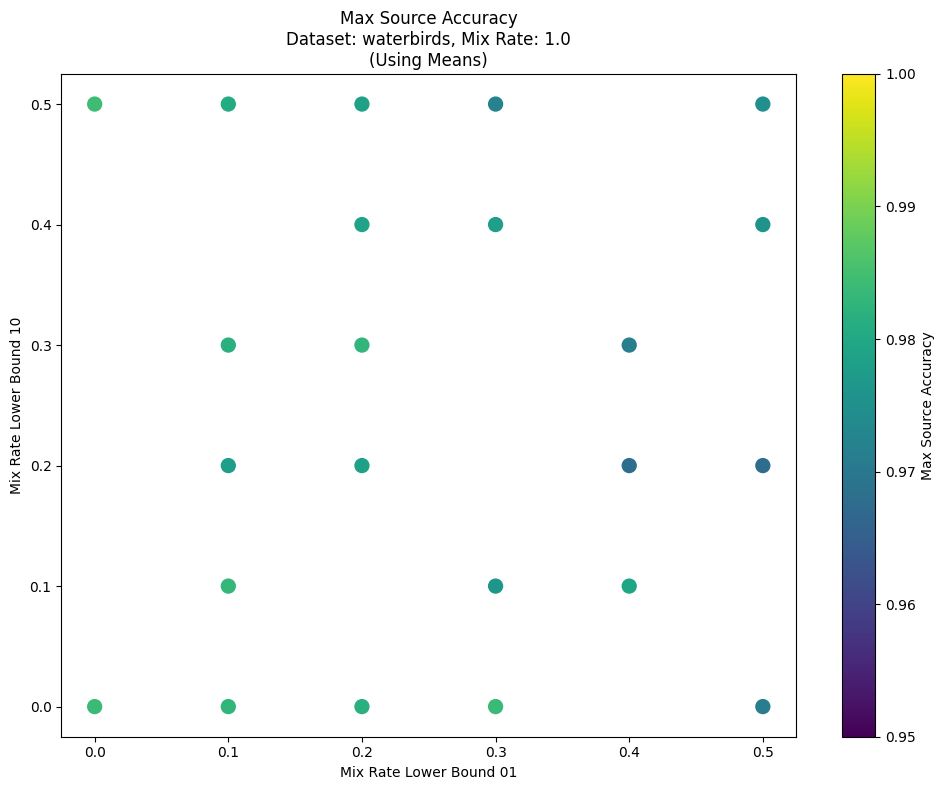

In [19]:
def plot_mix_rate_accuracy(df, dataset, mix_rate, figsize=(10, 8), vmin=0.5, vmax=1.0, use_means=False):
    """
    Plot scatter of max source accuracy for given dataset and mix rate.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to plot
        mix_rate: float, mix rate to plot
        figsize: tuple, size of the figure (width, height)
        vmin: float, minimum value for colorbar
        vmax: float, maximum value for colorbar
        use_means: bool, if True, plot means instead of raw data points
    """
    import matplotlib.pyplot as plt
    
    # Filter data for specific dataset and mix rate
    if use_means:
        mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
        data = df[mask]
        value_col = 'source_acc_mean'
    else:
        mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
        data = df[mask]
        value_col = 'source_acc'
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    scatter = plt.scatter(
        data['mix_rate_lb_01'], 
        data['mix_rate_lb_10'], 
        c=data[value_col],
        cmap='viridis',
        vmin=vmin,  # Set minimum value for color scale
        vmax=vmax,  # Set maximum value for color scale
        s=100  # Point size
    )
    
    # Add colorbar
    plt.colorbar(scatter, label='Max Source Accuracy')
    
    # Labels and title
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    title = f'Max Source Accuracy\nDataset: {dataset}, Mix Rate: {mix_rate}'
    if use_means:
        title += '\n(Using Means)'
    plt.title(title)
    
    plt.tight_layout()
    plt.show()

# Example usage:
mix_rate = 1.0
vmin = 0.95
vmax = 1.0

# Plot raw data
# plot_mix_rate_accuracy(df, dataset='waterbirds', mix_rate=mix_rate, vmin=vmin, vmax=vmax, use_means=False)

# Plot means
plot_mix_rate_accuracy(means, dataset='waterbirds', mix_rate=mix_rate, vmin=vmin, vmax=vmax, use_means=True)

In [10]:
# TODO: get ERM mean and std 
mean_source_accs = {
    'celebA-0': 0.996,
    'cifar_mnist': 1.0,
    'fmnist_mnist': 1.0,
    'toy_grid': 0.999,
    'waterbirds': 0.984
}

std_source_accs = {
    'celebA-0': 0.0,
    'cifar_mnist': 0.0,
    'fmnist_mnist': 0.0,
    'toy_grid': 0.002,
    'waterbirds': 0.004
}

In [17]:
# Compute means grouped by all relevant columns
means = df.groupby(['dataset', 'mix_rate', 'mix_rate_lb_01', 'mix_rate_lb_10']).agg({
    'source_acc': ['mean', 'std', 'count']
}).reset_index()

# Rename columns for clarity
means.columns = ['dataset', 'mix_rate', 'mix_rate_lb_01', 'mix_rate_lb_10', 
                'source_acc_mean', 'source_acc_std', 'n_samples']

# Sort values for easier reading
means = means.sort_values(['dataset', 'mix_rate', 'mix_rate_lb_01', 'mix_rate_lb_10'])

# Display the results
print(means)

         dataset  mix_rate  mix_rate_lb_01  mix_rate_lb_10  source_acc_mean  \
0    cifar_mnist       0.1             0.0             0.0         1.000000   
1    cifar_mnist       0.1             0.0             0.1         1.000000   
2    cifar_mnist       0.1             0.0             0.2         1.000000   
3    cifar_mnist       0.1             0.0             0.3         1.000000   
4    cifar_mnist       0.1             0.0             0.4         1.000000   
..           ...       ...             ...             ...              ...   
513   waterbirds       1.0             0.4             0.3         0.971444   
514   waterbirds       1.0             0.5             0.0         0.970905   
515   waterbirds       1.0             0.5             0.2         0.967672   
516   waterbirds       1.0             0.5             0.4         0.975216   
517   waterbirds       1.0             0.5             0.5         0.974677   

     source_acc_std  n_samples  
0          0.00000

In [16]:
# compute mean for each mix_rate_lb_01 and mix_rate_lb_10 (per dataset and mix rate)
df.groupby(['dataset', 'mix_rate', 'mix_rate_lb_01', 'mix_rate_lb_10'])


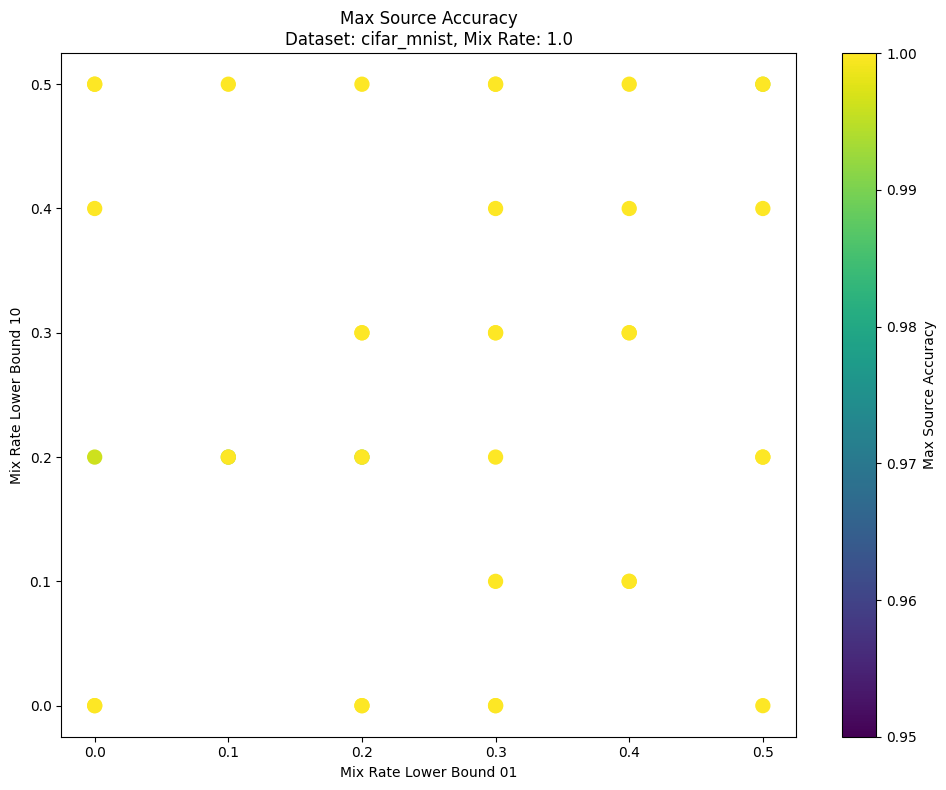

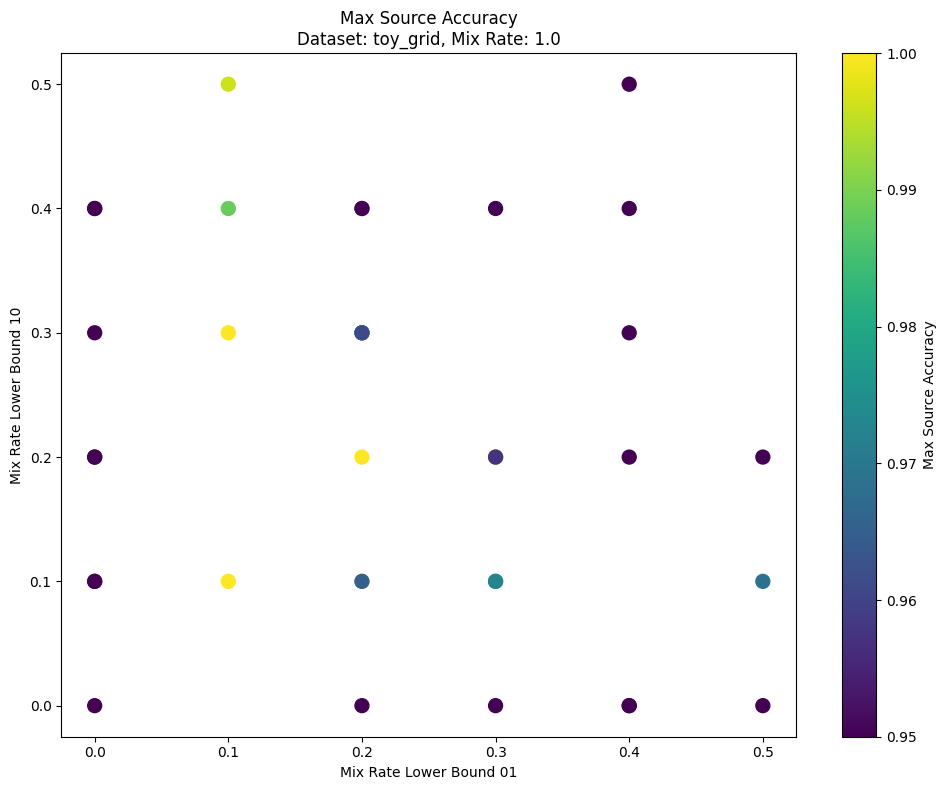

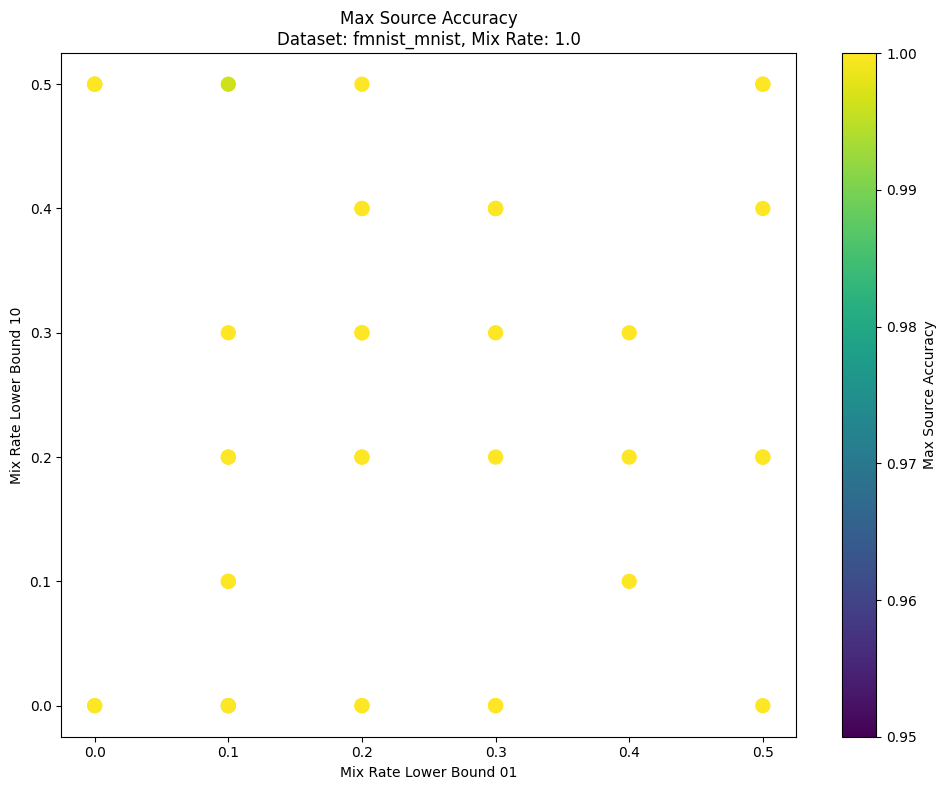

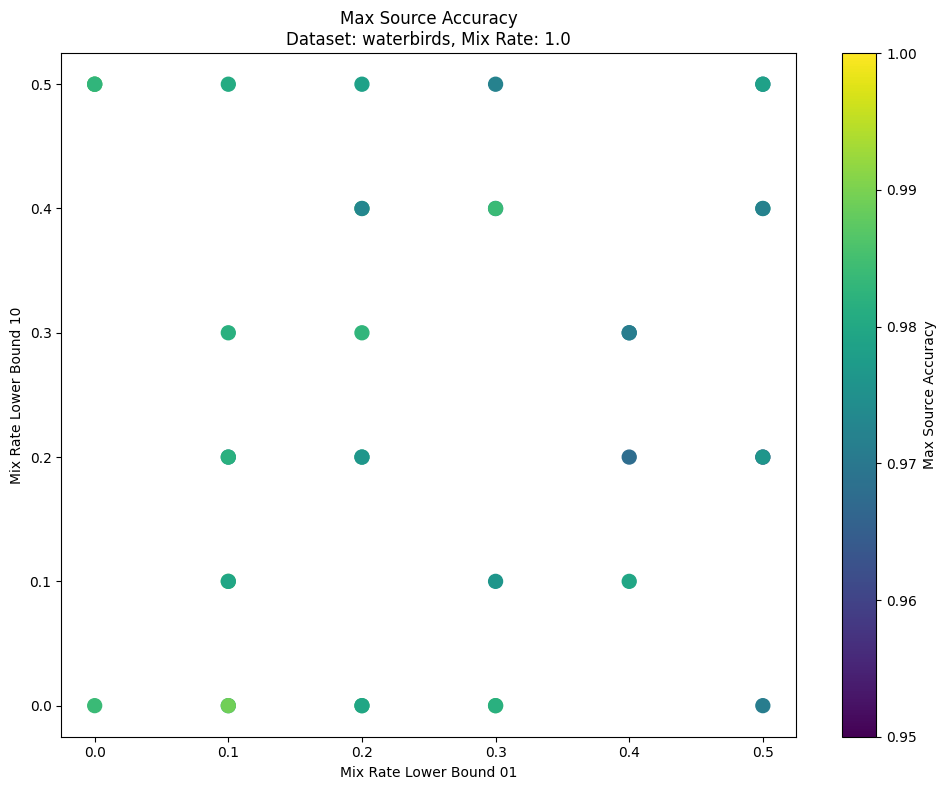

In [13]:
# Example usage:
mix_rate = 1.0
vmin = 0.95
vmax = 1.0
plot_mix_rate_accuracy(df, dataset='cifar_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='toy_grid', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='fmnist_mnist', mix_rate=mix_rate, vmin=vmin, vmax=vmax)
plot_mix_rate_accuracy(df, dataset='waterbirds', mix_rate=mix_rate, vmin=0.95, vmax=1.0)

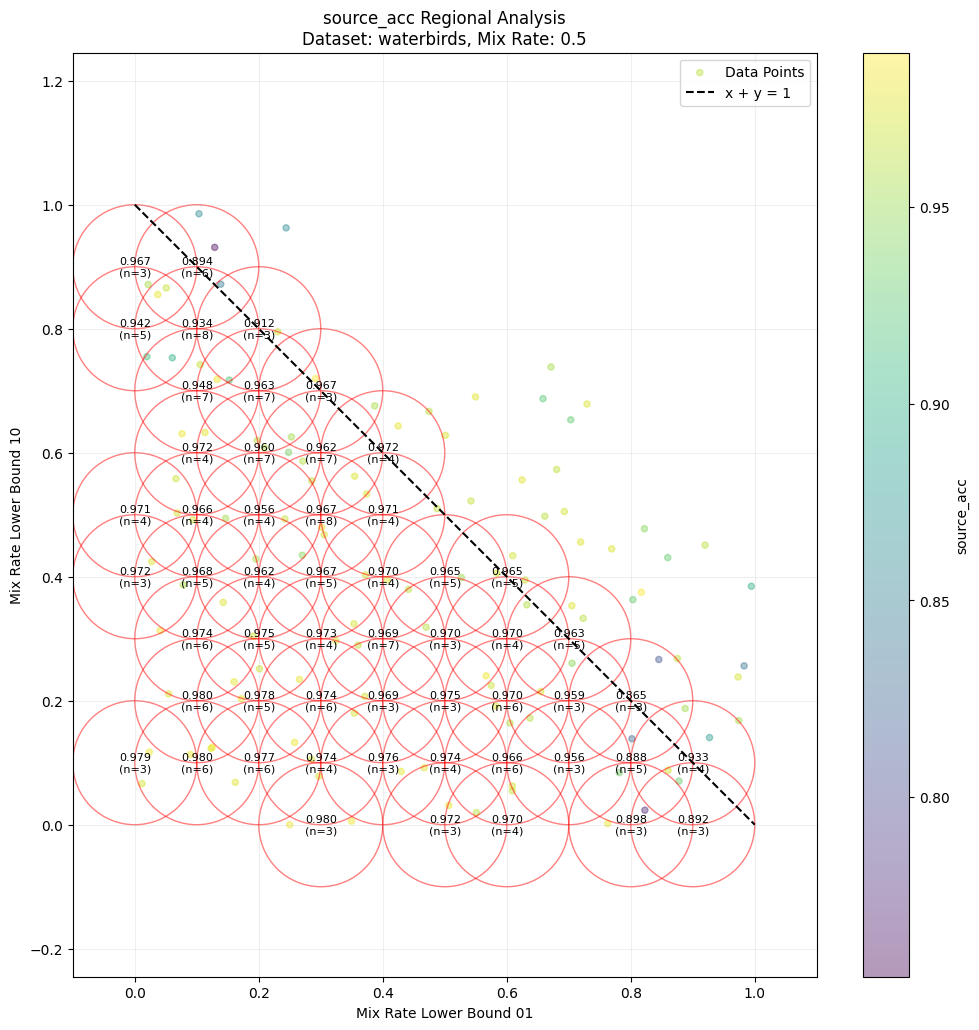

In [29]:
def analyze_accuracy_regions(df, dataset, mix_rate, metric='source_acc', 
                           radius=0.1, spacing=0.1, min_points=5):
    """
    Analyze accuracy metrics within circular regions for a given dataset and mix rate.
    
    Args:
        df: DataFrame containing results
        dataset: str, name of dataset to analyze
        mix_rate: float, mix rate to analyze
        metric: str, metric to analyze (e.g., 'source_acc', 'test_acc')
        radius: float, radius of circular regions
        spacing: float, spacing between circle centers
        min_points: int, minimum number of points required in a circle to compute statistics
    """
    # Filter data for specific dataset and mix rate
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    # Create centers for circles
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:  # Only include centers below x + y = 1 line
                centers.append([i, j])
    centers = np.array(centers)
    
    # Get points
    points = np.column_stack((data['mix_rate_lb_01'], data['mix_rate_lb_10']))
    values = data[metric].values
    
    # Compute statistics for each circle
    stats = []
    for center in centers:
        # Calculate distances from center to all points
        distances = np.sqrt(np.sum((points - center)**2, axis=1))
        # Get points within radius
        mask = distances <= radius
        points_in_circle = values[mask]
        
        if len(points_in_circle) >= min_points:
            stats.append({
                'center': center,
                'n_points': len(points_in_circle),
                'mean': np.mean(points_in_circle),
                'std': np.std(points_in_circle),
                'min': np.min(points_in_circle),
                'max': np.max(points_in_circle)
            })
    
    # Create plot
    plt.figure(figsize=(12, 12))
    
    # Plot original points
    plt.scatter(points[:, 0], points[:, 1], 
               c=values, cmap='viridis', 
               alpha=0.4, s=20, 
               label='Data Points')
    
    # Plot circles and add mean text
    for stat in stats:
        center = stat['center']
        circle = plt.Circle(center, radius, fill=False, color='red', alpha=0.5)
        plt.gca().add_patch(circle)
        # Add mean text
        plt.text(center[0], center[1], 
                f"{stat['mean']:.3f}\n(n={stat['n_points']})", 
                horizontalalignment='center', 
                verticalalignment='center',
                fontsize=8)
    
    # Plot constraint line x + y = 1
    x = np.linspace(0, 1, 100)
    y = 1 - x
    plt.plot(x, y, 'k--', label='x + y = 1')
    
    plt.xlabel('Mix Rate Lower Bound 01')
    plt.ylabel('Mix Rate Lower Bound 10')
    plt.title(f'{metric} Regional Analysis\nDataset: {dataset}, Mix Rate: {mix_rate}')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.axis('equal')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.colorbar(label=metric)
    plt.show()
    
    return stats

# Example usage:
dataset = 'waterbirds'
mix_rate = 0.5
stats = analyze_accuracy_regions(df, dataset, mix_rate, 
                               metric='source_acc',
                               radius=0.1, 
                               spacing=0.1,
                               min_points=3)

In [32]:
def find_optimal_regions(df, dataset, mix_rate, erm_mean, erm_std, 
                        radius=0.1, spacing=0.1, min_points=5):
    """
    Find regions that maintain accuracy within 1 std of ERM while maximizing mix rates.
    
    Args:
        df: DataFrame containing results
        dataset: str, name of dataset to analyze
        mix_rate: float, mix rate to analyze
        erm_mean: float, mean accuracy for ERM
        erm_std: float, standard deviation for ERM accuracy
        radius: float, radius of circular regions
        spacing: float, spacing between circle centers
        min_points: int, minimum number of points required in a circle
    """
    # Filter data
    mask = (df['dataset'] == dataset) & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset} and mix_rate={mix_rate}")
        return
    
    # Create centers grid
    x = np.arange(0, 1.1, spacing)
    y = np.arange(0, 1.1, spacing)
    centers = []
    for i in x:
        for j in y:
            if i + j <= 1:
                centers.append([i, j])
    centers = np.array(centers)
    
    # Get points
    points = np.column_stack((data['mix_rate_lb_01'], data['mix_rate_lb_10']))
    values = data['source_acc'].values
    
    # Analyze each region
    valid_regions = []
    for center in centers:
        distances = np.sqrt(np.sum((points - center)**2, axis=1))
        mask = distances <= radius
        points_in_circle = values[mask]
        
        if len(points_in_circle) >= min_points:
            mean_acc = np.mean(points_in_circle)
            std_acc = np.std(points_in_circle)
            
            # Check if accuracy is within 1 std of ERM
            if mean_acc >= (erm_mean - erm_std):
                total_mix_rate = center[0] + center[1]
                min_mix_rate = min(center[0], center[1])
                
                valid_regions.append({
                    'center': center,
                    'mean_acc': mean_acc,
                    'total_mix_rate': total_mix_rate,
                    'min_mix_rate': min_mix_rate,
                    'n_points': len(points_in_circle)
                })
    
    if not valid_regions:
        print("No valid regions found")
        return None
    
    # Find regions with maximum total and minimum mix rates
    max_total = max(r['total_mix_rate'] for r in valid_regions)
    max_min = max(r['min_mix_rate'] for r in valid_regions)
    
    max_total_region = [r for r in valid_regions if r['total_mix_rate'] == max_total][0]
    max_min_region = [r for r in valid_regions if r['min_mix_rate'] == max_min][0]
    
    print(f"\nResults for {dataset} (mix_rate={mix_rate}):")
    print(f"ERM baseline: {erm_mean:.3f} ± {erm_std:.3f}")
    print("\nMaximum total mix rate region:")
    print(f"Center: ({max_total_region['center'][0]:.2f}, {max_total_region['center'][1]:.2f})")
    print(f"Total mix rate: {max_total_region['total_mix_rate']:.2f}")
    print(f"Mean accuracy: {max_total_region['mean_acc']:.3f}")
    print(f"Points in region: {max_total_region['n_points']}")
    
    print("\nMaximum minimum mix rate region:")
    print(f"Center: ({max_min_region['center'][0]:.2f}, {max_min_region['center'][1]:.2f})")
    print(f"Min mix rate: {max_min_region['min_mix_rate']:.2f}")
    print(f"Mean accuracy: {max_min_region['mean_acc']:.3f}")
    print(f"Points in region: {max_min_region['n_points']}")
    
    return max_total_region, max_min_region

# Example usage:
datasets = ['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds']
mix_rates = [0.1, 0.25, 0.5, 0.75, 1.0]

for dataset in datasets:
    for mix_rate in mix_rates:
        find_optimal_regions(
            df, 
            dataset=dataset,
            mix_rate=mix_rate,
            erm_mean=mean_source_accs[dataset],
            erm_std=std_source_accs[dataset],
            radius=0.1,
            spacing=0.1,
            min_points=5
        )

No valid regions found
No valid regions found

Results for cifar_mnist (mix_rate=0.5):
ERM baseline: 1.000 ± 0.000

Maximum total mix rate region:
Center: (0.10, 0.20)
Total mix rate: 0.30
Mean accuracy: 1.000
Points in region: 5

Maximum minimum mix rate region:
Center: (0.10, 0.10)
Min mix rate: 0.10
Mean accuracy: 1.000
Points in region: 6
No valid regions found

Results for cifar_mnist (mix_rate=1.0):
ERM baseline: 1.000 ± 0.000

Maximum total mix rate region:
Center: (0.30, 0.40)
Total mix rate: 0.70
Mean accuracy: 1.000
Points in region: 6

Maximum minimum mix rate region:
Center: (0.30, 0.30)
Min mix rate: 0.30
Mean accuracy: 1.000
Points in region: 5

Results for toy_grid (mix_rate=0.1):
ERM baseline: 0.999 ± 0.002

Maximum total mix rate region:
Center: (0.10, 0.30)
Total mix rate: 0.40
Mean accuracy: 0.998
Points in region: 6

Maximum minimum mix rate region:
Center: (0.10, 0.30)
Min mix rate: 0.10
Mean accuracy: 0.998
Points in region: 6
No valid regions found
No valid regio

## Correlation Between Source Acc and Target Acc

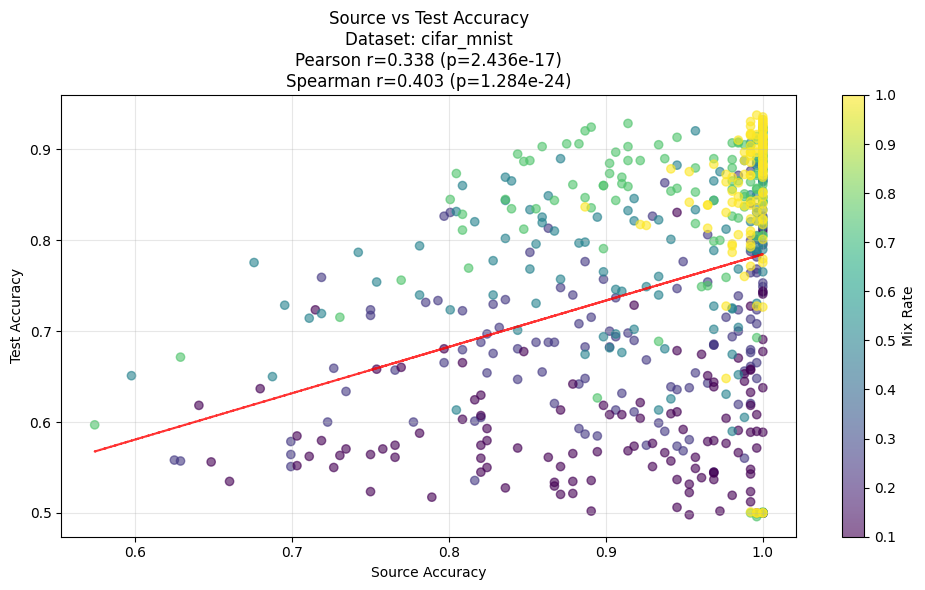

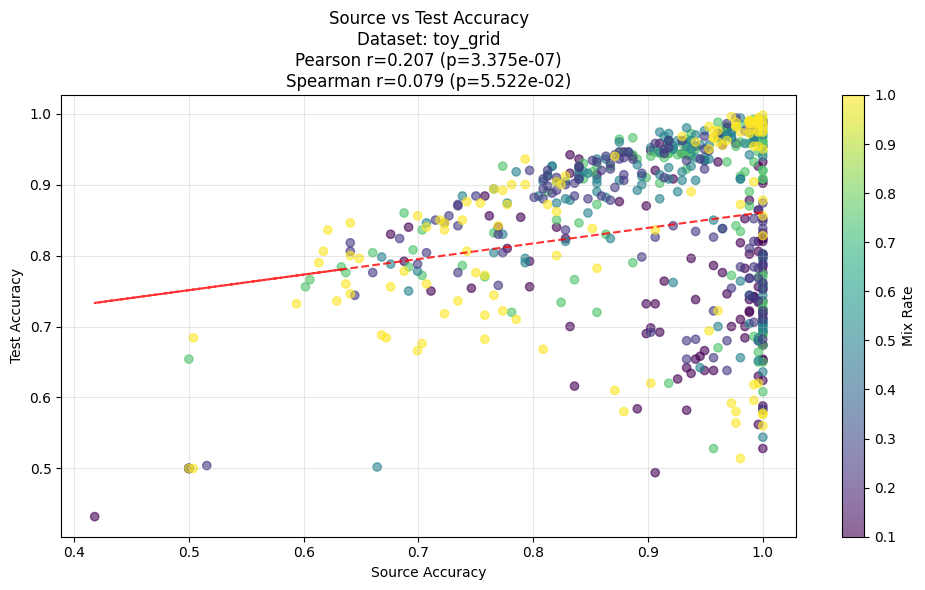

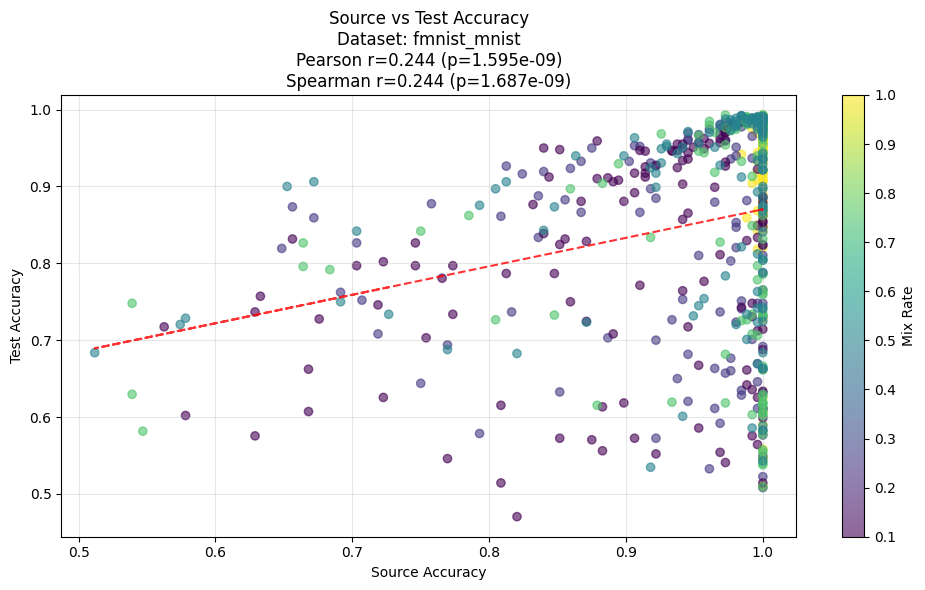

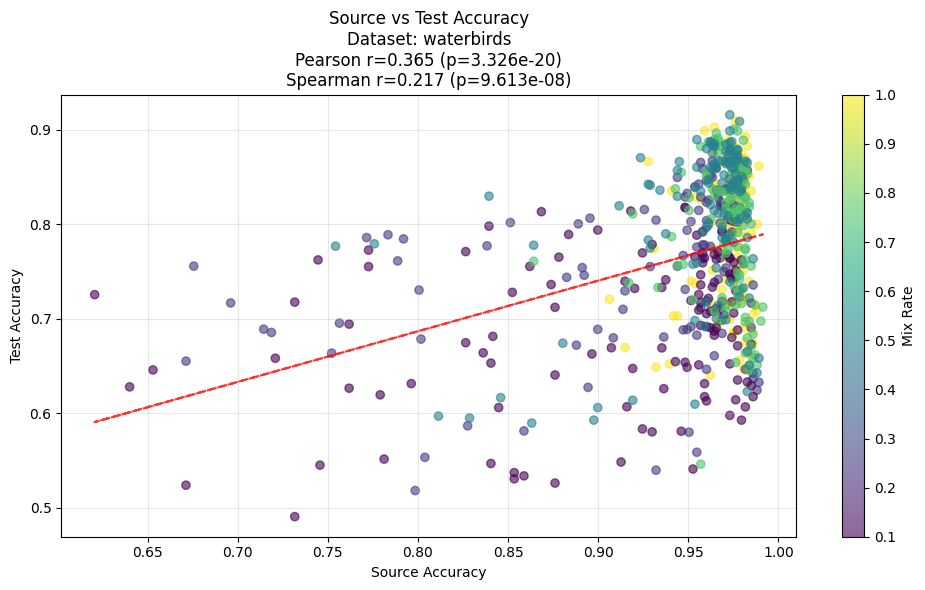

{'pearson_r': 0.3651421462796486,
 'pearson_p': 3.3263417057826496e-20,
 'spearman_r': 0.21652439308638502,
 'spearman_p': 9.612864592277381e-08}

In [33]:
def analyze_source_target_correlation(df, dataset, mix_rate=None, figsize=(10, 6)):
    """
    Analyze and plot correlation between source and target accuracy for a given dataset.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to analyze
        mix_rate: float or None, if specified, filter for specific mix rate
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Filter data
    mask = df['dataset'] == dataset
    if mix_rate is not None:
        mask = mask & (df['mix_rate'] == mix_rate)
    data = df[mask]
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset}" + 
              (f" and mix_rate={mix_rate}" if mix_rate is not None else ""))
        return
    
    # Compute correlation
    pearson_r, p_value = stats.pearsonr(data['source_acc'], data['test_acc'])
    spearman_r, spearman_p = stats.spearmanr(data['source_acc'], data['test_acc'])
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Scatter plot with color based on mix rate
    scatter = plt.scatter(
        data['source_acc'],
        data['test_acc'],
        c=data['mix_rate'] if mix_rate is None else data['mix_rate_lb_01'],
        cmap='viridis',
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mix Rate' if mix_rate is None else 'Mix Rate LB 01')
    
    # Add correlation line
    z = np.polyfit(data['source_acc'], data['test_acc'], 1)
    p = np.poly1d(z)
    plt.plot(data['source_acc'], p(data['source_acc']), "r--", alpha=0.8)
    
    # Labels and title
    plt.xlabel('Source Accuracy')
    plt.ylabel('Test Accuracy')
    title = f'Source vs Test Accuracy\nDataset: {dataset}'
    if mix_rate is not None:
        title += f'\nMix Rate: {mix_rate}'
    title += f'\nPearson r={pearson_r:.3f} (p={p_value:.3e})'
    title += f'\nSpearman r={spearman_r:.3f} (p={spearman_p:.3e})'
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

# Example usage:
# For all mix rates:
analyze_source_target_correlation(df, dataset='cifar_mnist')
analyze_source_target_correlation(df, dataset='toy_grid')
analyze_source_target_correlation(df, dataset='fmnist_mnist')
analyze_source_target_correlation(df, dataset='waterbirds')

## Correlation Between Min(Mix Rate LB - Mix RATE, 0) and Source Acc

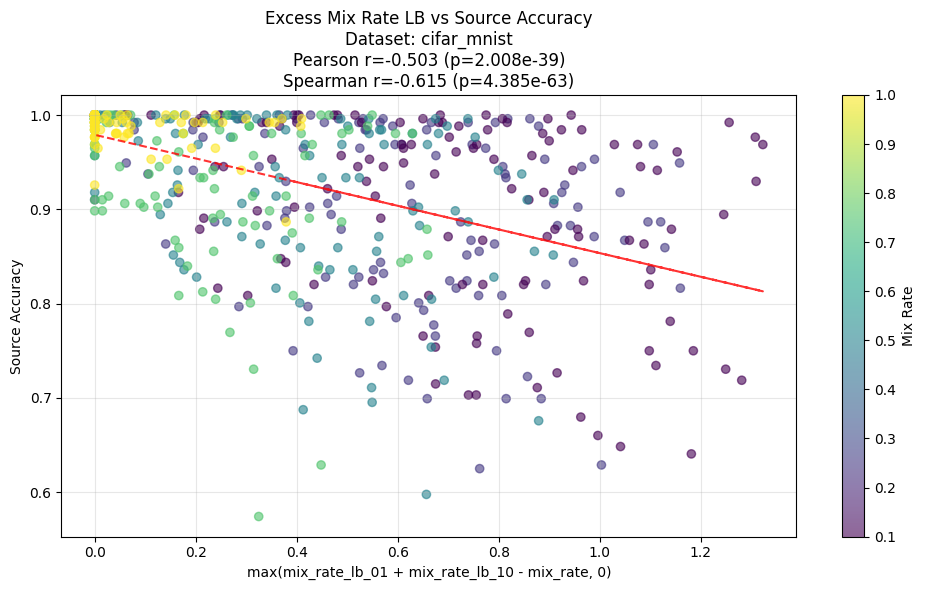

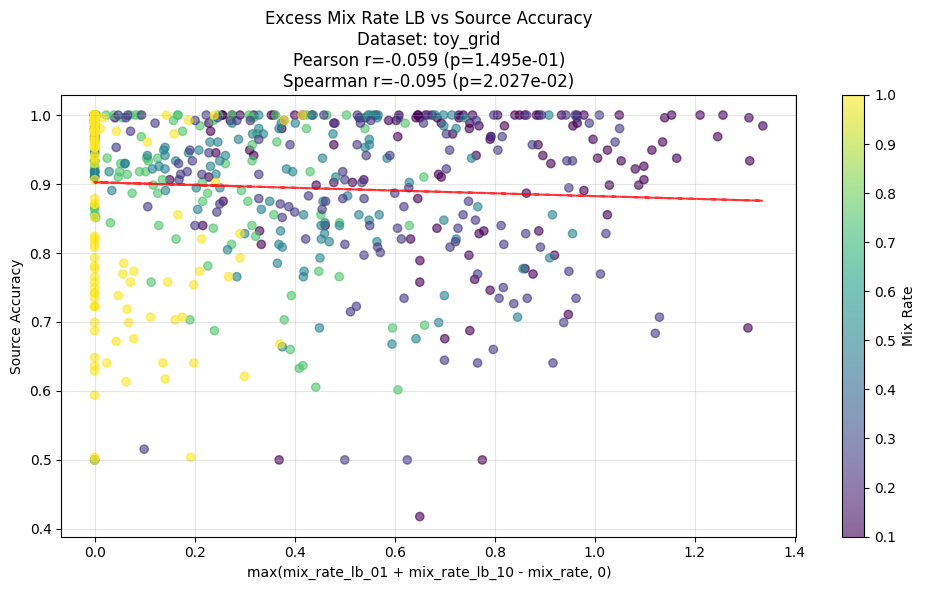

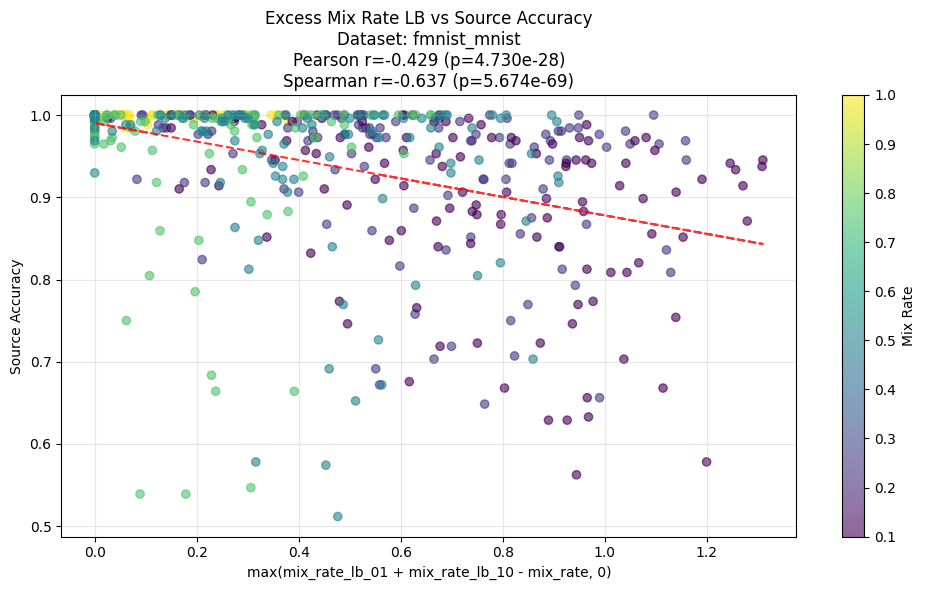

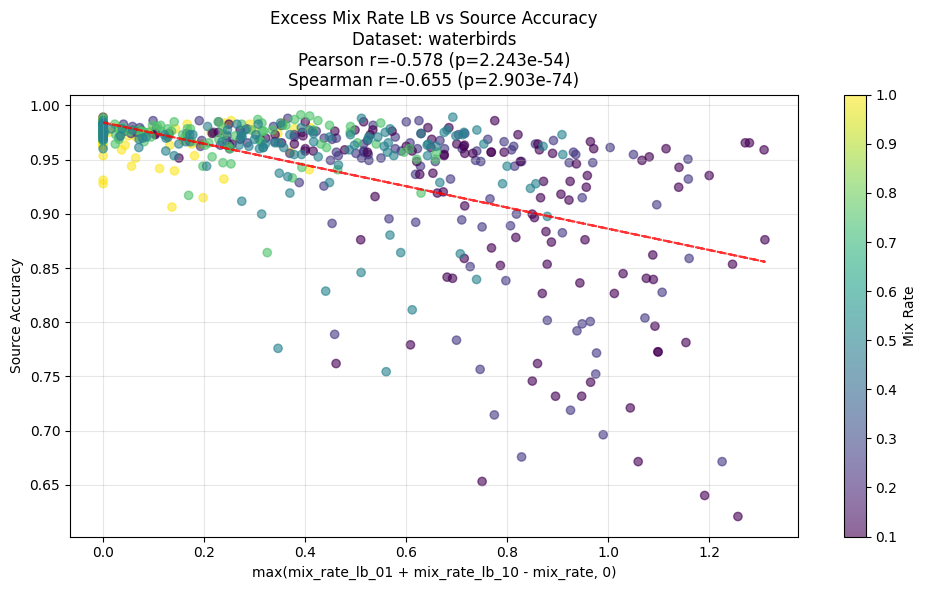

In [34]:
def analyze_mix_rate_lb_correlation(df, dataset, mix_rate=None, figsize=(10, 6)):
    """
    Analyze and plot correlation between excess mix rate lower bound and source accuracy.
    
    Args:
        df: DataFrame containing the results
        dataset: str, name of dataset to analyze
        mix_rate: float or None, if specified, filter for specific mix rate
        figsize: tuple, size of the figure (width, height)
    """
    import matplotlib.pyplot as plt
    from scipy import stats
    
    # Filter data
    mask = df['dataset'] == dataset
    if mix_rate is not None:
        mask = mask & (df['mix_rate'] == mix_rate)
    data = df[mask].copy()  # Create copy to avoid SettingWithCopyWarning
    
    if len(data) == 0:
        print(f"No data found for dataset={dataset}" + 
              (f" and mix_rate={mix_rate}" if mix_rate is not None else ""))
        return
    
    # Calculate excess mix rate lower bound
    data['excess_mix_rate_lb'] = np.maximum(
        data['mix_rate_lb_01'] + data['mix_rate_lb_10'] - data['mix_rate'],
        0
    )
    
    # Compute correlation
    pearson_r, p_value = stats.pearsonr(data['excess_mix_rate_lb'], data['source_acc'])
    spearman_r, spearman_p = stats.spearmanr(data['excess_mix_rate_lb'], data['source_acc'])
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Scatter plot
    scatter = plt.scatter(
        data['excess_mix_rate_lb'],
        data['source_acc'],
        c=data['mix_rate'],
        cmap='viridis',
        alpha=0.6
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mix Rate')
    
    # Add correlation line
    z = np.polyfit(data['excess_mix_rate_lb'], data['source_acc'], 1)
    p = np.poly1d(z)
    plt.plot(data['excess_mix_rate_lb'], p(data['excess_mix_rate_lb']), "r--", alpha=0.8)
    
    # Labels and title
    plt.xlabel('max(mix_rate_lb_01 + mix_rate_lb_10 - mix_rate, 0)')
    plt.ylabel('Source Accuracy')
    title = f'Excess Mix Rate LB vs Source Accuracy\nDataset: {dataset}'
    if mix_rate is not None:
        title += f'\nMix Rate: {mix_rate}'
    title += f'\nPearson r={pearson_r:.3f} (p={p_value:.3e})'
    title += f'\nSpearman r={spearman_r:.3f} (p={spearman_p:.3e})'
    plt.title(title)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'pearson_r': pearson_r,
        'pearson_p': p_value,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p
    }

# Example usage:
for dataset in ['cifar_mnist', 'toy_grid', 'fmnist_mnist', 'waterbirds']:
    analyze_mix_rate_lb_correlation(df, dataset=dataset)

# Sett

In [ ]:
# can I make this into a score? 

# no 


# ok just look else where for the mean,std erm 

# bin the mix rates into 10 bins 
# compute mean across bins for each dataset and mix rate 
# compute highest assumed mix rate within one standard deviation 
# 

In [ ]:
# so there's signal here, its just a matter of setting thresholds
# I think 